# Kaggle - Brain Tumor MRI Dataset

You can find the dataset and some informations about on the [Kaggle page](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

For details on steps below, please see documentation in the *docs* directory.

## General part

In [1]:
from pathlib import Path
import ipynbname
import os
import tqdm
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
NOTEBOOK_PATH = Path(ipynbname.path())
PROJECT_ROOT = Path(NOTEBOOK_PATH).resolve().parents[1]
DATA_DIR = PROJECT_ROOT / "data/raw"

CLASSES = ["notumor", "glioma", "meningioma", "pituitary"]

In [3]:
def load_dataset(raw_data_path: Path, dataset_dir: str, classes: list) -> list:
    """
    raw_data_path : path do data raw
    dataset_dir : Training or Testing
    """
    folder_path = raw_data_path / dataset_dir
    dataset = []
    img_files = []
    for class_label in classes:
        class_path = folder_path / class_label
        label_index = classes.index(class_label)
        for img_file in tqdm.tqdm(os.listdir(class_path)):
            if img_file in img_files:
                print("Doublon : {}", img_file)
            else:
                img_files.append(img_file)
            img_path = class_path / img_file
            img = cv2.imread(img_path)
            #img = cv2.resize(img, (224, 224))
            dataset.append((img, label_index))
    return dataset

In [4]:
raw_data = load_dataset(DATA_DIR, "Training", CLASSES)

100%|██████████| 1457/1457 [00:06<00:00, 233.73it/s]


## EDA

### Shape
#### Images shapes

In [5]:
len(raw_data)

5712

In [6]:
raw_data[0][0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]]], shape=(250, 201, 3), dtype=uint8)

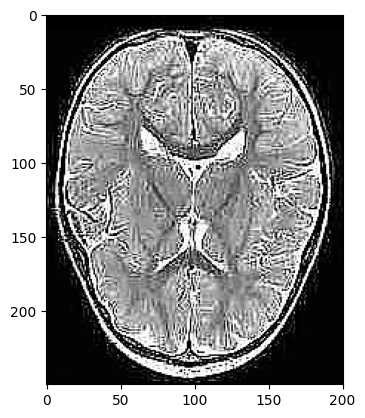

In [7]:
plt.imshow(raw_data[0][0])

In [21]:
def count_shape(raw_data):
    shapes = {
        "nb_pix":[],
        "width": [],
        "height": [],
        "colors": [],
        "class": []
             }
    for i in range(0,len(raw_data)):
        dim = raw_data[i][0].shape
        lbl = raw_data[i][1]
        for key, i in zip(shapes.keys(), range(len(shapes.keys()))):
            if i == 0:
                shapes[key].append(dim[0]*dim[1])
            elif i == 4:
                shapes[key].append(lbl)
            else:
                shapes[key].append(dim[i-1])

    return pd.DataFrame.from_dict(shapes)

In [22]:
df_shapes = count_shape(raw_data)

In [23]:
df_shapes.value_counts()

nb_pix   width  height  colors  class
262144   512    512     3       3        1418
                                1        1321
                                2        1199
50625    225    225     3       0         260
396900   630    630     3       0          77
                                         ... 
63736    248    257     3       2           1
63720    270    236     3       0           1
63288    293    216     3       0           1
63248    268    236     3       0           1
2073600  1080   1920    3       0           1
Name: count, Length: 394, dtype: int64

nb_pix
262144    3955
50625      268
396900      77
50400       71
55696       53
          ... 
554400       1
47436        1
224664       1
112671       1
136080       1
Name: count, Length: 368, dtype: int64
width
512    3962
225     277
236      79
630      77
442      72
       ... 
344       1
450       1
781       1
488       1
378       1
Name: count, Length: 230, dtype: int64
height
512    3955
225     270
236     145
630      79
201      73
       ... 
421       1
446       1
237       1
456       1
360       1
Name: count, Length: 199, dtype: int64
colors
3    5712
Name: count, dtype: int64
class
0    1595
3    1457
2    1339
1    1321
Name: count, dtype: int64


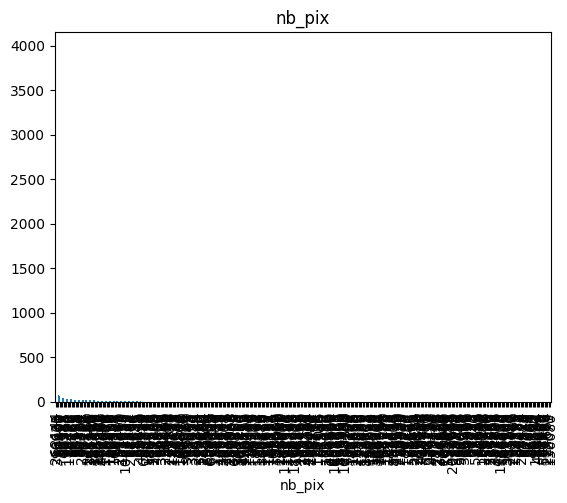

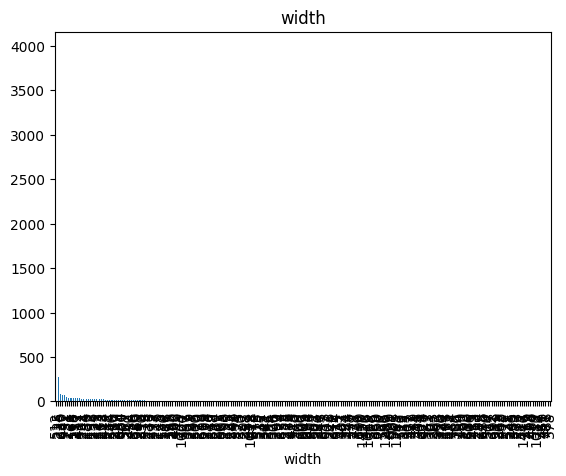

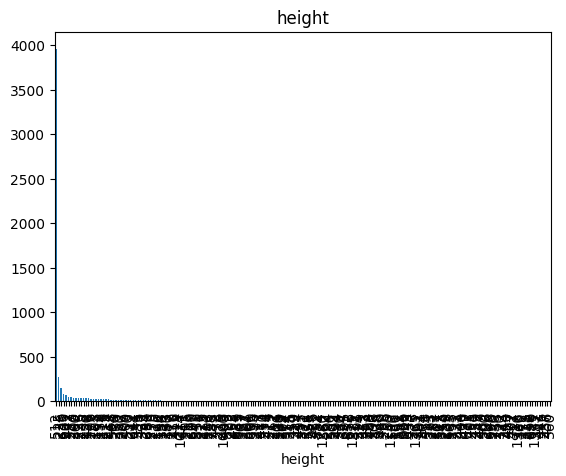

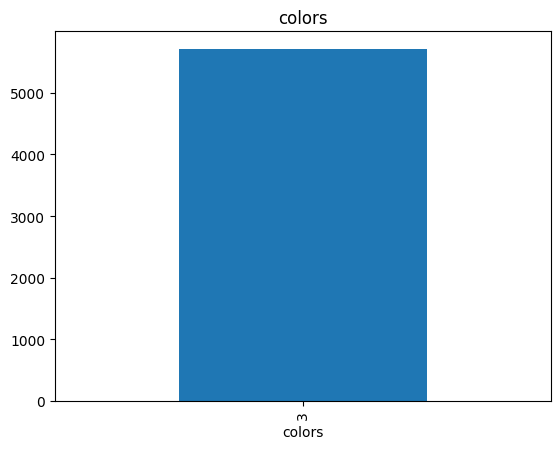

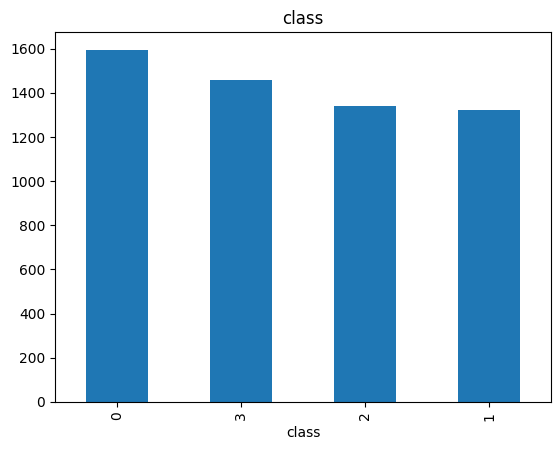

In [24]:
for col in df_shapes.columns:
    plt.figure()
    count = df_shapes[col].value_counts()
    print(count)
    count.plot.bar()
    plt.title(col)

### Content

#### Target visualization

In [14]:
def count_label(raw_data, classes):
    count_lbl = {}
    for lbl in classes:
        count_lbl[lbl] = 0

    for i in range(0, len(raw_data)):
        lbl = raw_data[i][1]
        count_lbl[classes[lbl]] += 1

    return count_lbl

In [15]:
count_label(raw_data, CLASSES)

{'notumor': 1595, 'glioma': 1321, 'meningioma': 1339, 'pituitary': 1457}

#### Images orientation

In [32]:
def check_orientation(df_shapes, classes):
    orientation_count = {}
    for elm in (['total'] + classes):
        orientation_count[elm] = {
            'portrait': 0,
            'landscape': 0,
            'square': 0,
        }

    for index, row in df_shapes.iterrows():
        w = row['width']
        h = row['height']
        c = classes[row['class']]
        if h > w:
            orientation = 'portrait'
        elif h < w:
            orientation = 'landscape'
        else:
            orientation = 'square'
        orientation_count['total'][orientation] += 1
        orientation_count[c][orientation] += 1

    return orientation_count

In [34]:
orientation_count = check_orientation(df_shapes, CLASSES)
orientation_count

{'total': {'portrait': 389, 'landscape': 829, 'square': 4494},
 'notumor': {'portrait': 355, 'landscape': 735, 'square': 505},
 'glioma': {'portrait': 0, 'landscape': 0, 'square': 1321},
 'meningioma': {'portrait': 30, 'landscape': 91, 'square': 1218},
 'pituitary': {'portrait': 4, 'landscape': 3, 'square': 1450}}

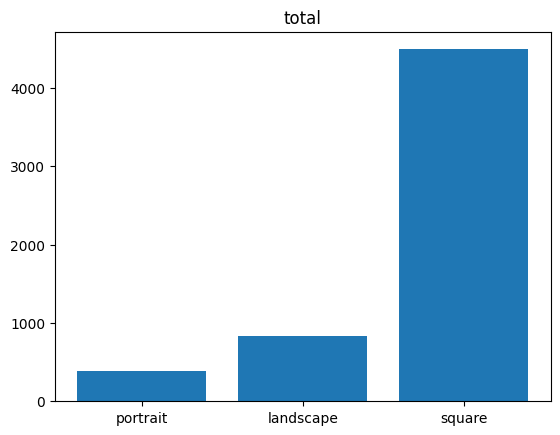

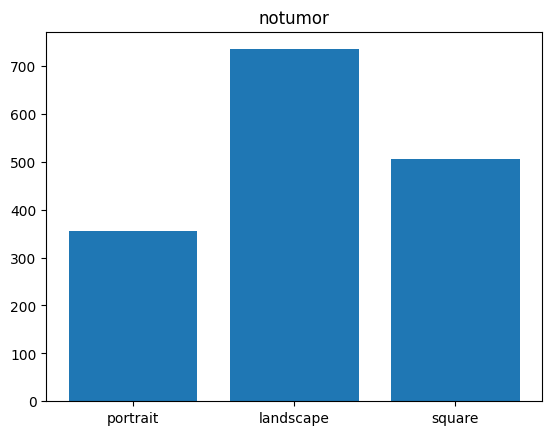

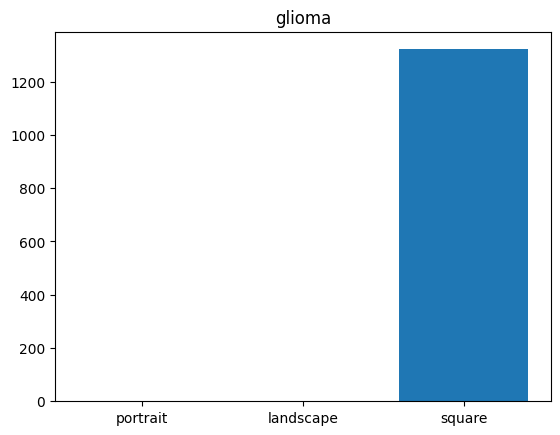

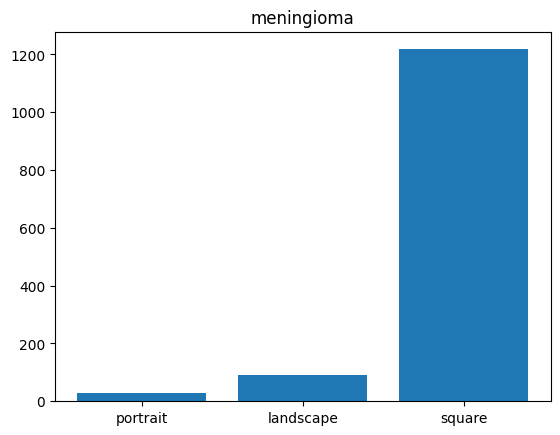

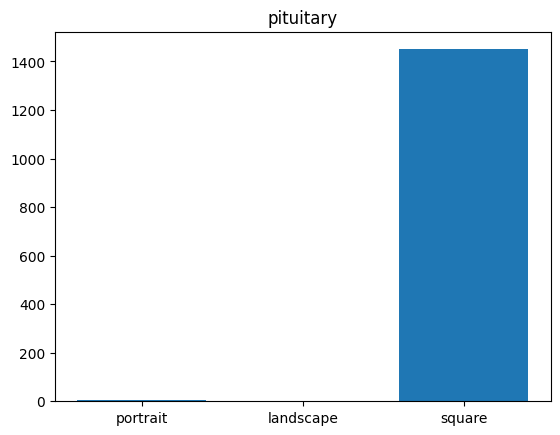

In [39]:
for label in orientation_count:
    plt.figure()
    plt.bar(*zip(*orientation_count[label].items()))
    plt.title(label)

#### Images view